In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set()

In [2]:
categ = pd.read_csv("ravdess_categorical.csv")
quant = pd.read_csv("ravdess_quantitative.csv")

print(len(quant.columns))
display(categ.head())
display(quant.head())
categ.drop(columns=["actor"], inplace=True)

18


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F


,kur,length_ms,mean,mfcc_max,mfcc_mean,mfcc_std,sc_kur,sc_max,sc_mean,sc_min,sc_skew,sc_std,skew,stft_kur,stft_mean,stft_min,stft_std,zcs
0,2.241354,3737,0.516733,171.69092,-33.485947,134.654860,-1.120769,0.766460,5792.550744,1250.763583,0.250940,3328.055457,0.273153,-1.215025,0.415250,-3.554547,0.335533,16995
1,2.973701,3904,0.492286,205.00770,-29.502108,130.485630,-1.531204,0.476926,5197.620555,950.006542,0.219582,4040.931570,0.292157,-1.384174,0.417488,-3.713009,0.352380,13906
2,1.585399,4671,0.576708,165.45653,-30.532463,126.577110,-1.130153,0.479789,4830.743037,1056.726022,0.436699,3332.131300,0.302659,-1.242947,0.379758,-4.135207,0.352270,18723
3,2.568041,3637,0.509706,190.03609,-36.059555,159.725160,-1.497765,0.494705,5376.446478,995.995071,0.098802,4053.663073,-0.081014,-1.445318,0.407277,-4.031363,0.360552,11617
4,2.012916,4404,0.535177,161.13400,-31.405996,122.125824,-1.167544,0.486484,5146.012474,1085.672654,0.496066,3442.724109,0.414872,-1.366742,0.415974,-3.927345,0.350655,15137


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [4]:
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, mutual_info_score
X = StandardScaler().fit_transform(quant.values)

## K-means

In [5]:
from sklearn.cluster import KMeans

N = 20
sil = np.zeros(N)
label_number = np.zeros(N)
max_mutual_info = np.zeros(N)
mean_mutual_info = np.zeros(N)
nmeans = range(2,N+2)

for i,nm in enumerate(nmeans):
    clustering = KMeans(n_clusters=nm, n_init=10, max_iter=100).fit(X)
    if len(np.unique(clustering.labels_)) > 1:
        sil[i] = silhouette_score(X, clustering.labels_)
        label_number[i] = len(np.unique(clustering.labels_))
    else:
        sil[i] = 0
        label_number[i] = 1
        
    if np.all(clustering.labels_==-1):
            label_number[i] = -1

    for cat in categ.columns:
        max_mutual_info[i] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), max_mutual_info[i])
        mean_mutual_info[i] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)

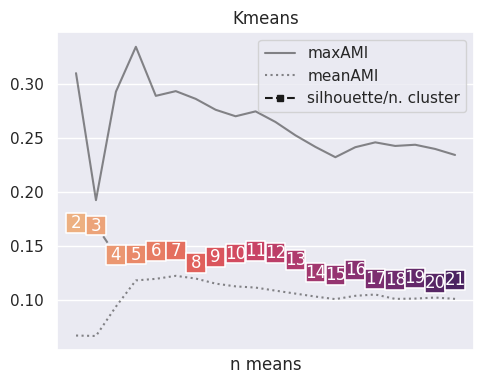

In [6]:
dummy_df = pd.DataFrame()
dummy_df["n means"] = nmeans
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number
dummy_df["maxAMI"] = max_mutual_info
dummy_df["meanAMI"] = mean_mutual_info

fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dummy_df, x="n means", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dummy_df, x="n means", y="meanAMI", color="k", alpha=0.5, ls=":")

sns.lineplot(data=dummy_df, x="n means", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="n means", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 1:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["n means"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    Line2D([0], [0], color='k', alpha=0.5, ls=":", label='meanAMI'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Kmeans")
plt.ylabel("")
plt.xticks([])
plt.savefig("Kmeans_sil.pdf")

/tmp/ipykernel_12828/2869937771.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)
/tmp/ipykernel_12828/2869937771.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)
/tmp/ipykernel_12828/2869937771.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True

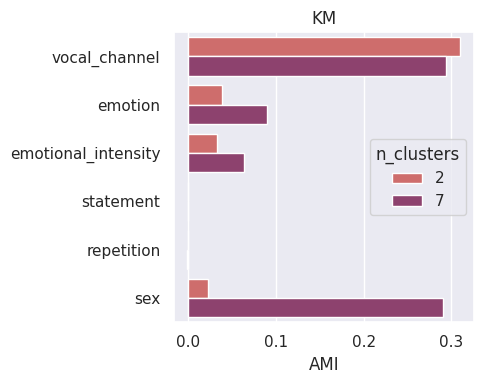

In [7]:
fig, ax = plt.subplots(figsize=(5,4))

mi_df= pd.DataFrame(columns = ["category", "AMI", "n_clusters"])
clustering = KMeans(n_clusters=2, n_init=5, max_iter=100).fit(X)

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)


clustering = KMeans(n_clusters=7, n_init=5, max_iter=100).fit(X)
for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":7  }), ignore_index=True)

sns.barplot(data=mi_df, x ="AMI", y="category", hue="n_clusters", palette="flare")

plt.ylabel("")
# plt.legend([],[], frameon=False)
plt.title("KM")
plt.savefig("Kmeans_MI.pdf")

## Bisecting K-means

In [8]:
from sklearn.cluster import BisectingKMeans
N = 20
sil = np.zeros(N)
label_number = np.zeros(N)
max_mutual_info = np.zeros(N)
mean_mutual_info = np.zeros(N)
nmeans = range(2,N+2)

for i,nm in enumerate(nmeans):
    clustering = BisectingKMeans(n_clusters=nm, n_init=10, max_iter=100).fit(X)
    if len(np.unique(clustering.labels_)) > 1:
        sil[i] = silhouette_score(X, clustering.labels_)
        label_number[i] = len(np.unique(clustering.labels_))
    else:
        sil[i] = 0
        label_number[i] = 1
        
    if np.all(clustering.labels_==-1):
            label_number[i] = -1

    for cat in categ.columns:
        max_mutual_info[i] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), max_mutual_info[i])
        mean_mutual_info[i] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)

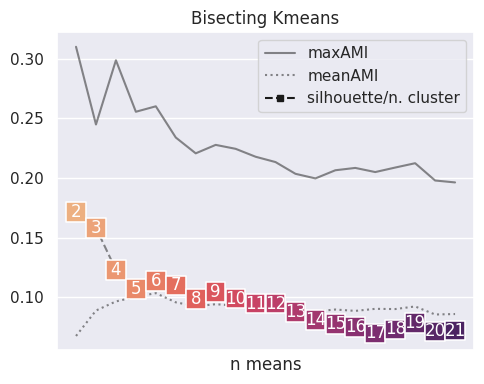

In [9]:
dummy_df = pd.DataFrame()
dummy_df["n means"] = nmeans
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number
dummy_df["maxAMI"] = max_mutual_info
dummy_df["meanAMI"] = mean_mutual_info

fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dummy_df, x="n means", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dummy_df, x="n means", y="meanAMI", color="k", alpha=0.5,ls=":")

sns.lineplot(data=dummy_df, x="n means", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="n means", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 1:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["n means"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    Line2D([0], [0], color='k', alpha=0.5, ls=":", label='meanAMI'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Bisecting Kmeans")
plt.ylabel("")
plt.xticks([])

plt.savefig("BisectingKmeans_sil.pdf")

/tmp/ipykernel_12828/3539621363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)
/tmp/ipykernel_12828/3539621363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)
/tmp/ipykernel_12828/3539621363.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True

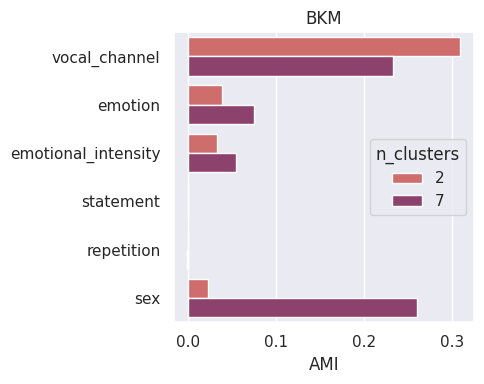

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

mi_df= pd.DataFrame(columns = ["category", "AMI", "n_clusters"])
clustering = BisectingKMeans(n_clusters=2, n_init=5, max_iter=300).fit(X)

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":2 }), ignore_index=True)


clustering = BisectingKMeans(n_clusters=6, n_init=5, max_iter=300).fit(X)
for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "n_clusters":7  }), ignore_index=True)

sns.barplot(data=mi_df, x ="AMI", y="category", hue="n_clusters", palette="flare")

plt.ylabel("")
# plt.legend([],[], frameon=False)
plt.title("BKM")
plt.savefig("BisectingKmeans_MI.pdf")